### Probelm Definition
The ONET database is a survey of experts and current employees about the requirements of each occupation (job).The database contains 36 excel files where each file describes one feature . Our goal is estimate the probability of an occupation being ANALYTICAL considering the given combination of feature.

### Let's Begin!

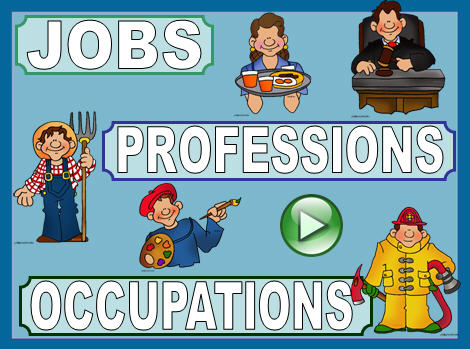

In [2]:
from IPython.display import Image
Image(filename='Occ_pic.jpg')


### Importing of all necessary libraries for building our model

In [32]:
import pandas as pd
import numpy as np

# For preprocessing the data
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
# To split the dataset into train and test datasets
#from sklearn  import train_test_split
# To model the Gaussian Navie Bayes classifier
from sklearn.naive_bayes import GaussianNB
# To calculate the accuracy score of the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from scipy import stats
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PowerTransformer
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

Before jumping on to our model building process we need to get our data and features ready so that the model can efficiently learn and estimste probabilities.

Our complete prcess can be split into following 4 modules

### 1)Data Collection

### 2)Data Exploartion

### 3)Data Preprocessing and Transformation

### 4)Model Building

### 5)Results

***Note: Since I am not aware about the background of the audience reviewing this notebook,I would be explaining every detail of the program.***

### 1) Data Collection
I have downloaded the Zip folder from the ONET 's site .The ONET database contains a rich set of variables that describe work and worker characteristics, including skill requirements,abilities, task activities to name a few. I have considered 3 Excel files out of the 36 excel features file. 
The 3 files are 'Occupation Description' ,'Work Activities' and 'Abilities'.

**Occupation Description**: This file contains ONET-SOC code, occupational title, and definition/description of the Occupation.

**Work Activities**: This file contains the  Work Activities associated with each ONET-SOC occupation

**Abilities** :This file contains the  Abilities associated with each ONET-SOC occupation


In [4]:
try:
    occ_data=pd.read_excel("Occupation Data.xlsx")
    work_activities=pd.read_excel("Work Activities.xlsx")
    abilities=pd.read_excel("Abilities.xlsx")
except:
    print("File not loaded.Make sure that excel files are in the current working directory")

**Total Number of rows and columns of each data file is as shown.**

In [5]:
print("Number of rows and columns in Occupation File is {}".format(occ_data.shape))
print("Number of rows and columns in Work Activities File is {}".format(work_activities.shape))
print("Number of rows and columns in Occupation File is {}".format(abilities.shape))

Number of rows and columns in Occupation File is (1110, 4)
Number of rows and columns in Work Activities File is (79294, 15)
Number of rows and columns in Occupation File is (100568, 15)


**Since the data was not originaly labelled , I have labelled a sample of the data based on the description given into Analytical (labeled as 1) and non Analytical(labeled as 0)**

In [8]:
Sampled_data1=occ_data[occ_data['Label']!=1].sample(80,replace=False,random_state=25)
data=[occ_data[occ_data['Label']==1],Sampled_data1]
Sampled_data=pd.concat(data)

### 2) Data Exploration

**I have used Tableau Dashboard to create some visuals for our analysis as they are interactive and faster to build**


**The [1st graph](https://public.tableau.com/views/Book1-Analytical/Sheet1?:embed=y&:display_count=yes&publish=yes) shows the average data value for each occupation with respect to each ability.I have put a filter on the title to understand what are the most important abilities for Analytical occupations**

**From the plot it can be deduced that abilities important for Analytical Occupations are Deductive reasoning,Inductive Reasoning,Fluency of Ideas,Mathematical reasoning to name a few.**

In [6]:
%%HTML
<iframe src="https://public.tableau.com/views/Book1-Analytical/Sheet1?:embed=y&:display_count=yes&publish=yes" width=900 height=500></iframe>


**The [2nd graph](https://public.tableau.com/views/WorkActivities/Sheet1?:embed=y&:display_count=yes&publish=yes) shows the average data value for each occupation with respect to workactivities associated with them**

**From the plot it can be deduced that work activities important for Analytical Occupations are Getting Information,Evaluating Information ,Making Descisions to name a few.**

In [7]:
%%HTML
<iframe src="https://public.tableau.com/views/WorkActivities/Sheet1?:embed=y&:display_count=yes&publish=yes" width=900 height=500></iframe>


In [9]:
Sampled_data.shape

(103, 4)

## 3) Data preprocessing and transformation
****The goal of this phase is to use raw data and process it into a form that can be plugged as an input into your  model.****

From our **Abilities** file we extract only  4 relevant columns ONET SOC CODE,Title,Element Name,Data Value to build our model.

**ONET SOC CODE**:Unique Code for each occupation
    
**Title**: Occupation name
    
**Element Name**: Abilities associated with each occupation
    
**Data Value**: Contains rating for each abilities associated to a occupation.

****I will be considering Data Value column to create abilities features for the model.I have used [Pands Pivot Table](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html) to create feature for each occupation with aggregated data values of each abilities as columns with respect to a occupation as rows**** 

The abilities dataframe after transformation is as shown


In [10]:
ab_data=abilities[['O*NET-SOC Code', 'Title',  'Element Name','Data Value']]
temp_abilities_data=pd.pivot_table(ab_data, values='Data Value', index=['Title'],columns=['Element Name'], aggfunc=np.mean)
print("The abilities dataframe after transformation is as shown:")
temp_abilities_data.head(5)


The abilities dataframe after transformation is as shown:


Element Name,Arm-Hand Steadiness,Auditory Attention,Category Flexibility,Control Precision,Deductive Reasoning,Depth Perception,Dynamic Flexibility,Dynamic Strength,Explosive Strength,Extent Flexibility,...,Speed of Limb Movement,Stamina,Static Strength,Time Sharing,Trunk Strength,Visual Color Discrimination,Visualization,Wrist-Finger Speed,Written Comprehension,Written Expression
Title,,,,,,,,,,,,,,,,,,,,,
Accountants,1.065,1.500,3.500,0.88,4.000,1.250,0.5,0.815,0.50,0.500,...,0.50,0.500,0.500,2.375,1.06,1.875,2.315,1.000,4.125,3.815
Actors,1.875,1.940,2.875,0.50,2.940,0.500,0.5,1.940,1.19,1.940,...,0.50,1.875,1.940,2.815,2.38,1.940,2.560,0.685,3.690,3.130
Actuaries,0.620,1.810,3.940,0.50,4.435,1.185,0.5,0.500,0.50,0.500,...,0.50,0.500,0.500,2.440,1.06,1.875,2.690,0.750,4.310,3.875
Acupuncturists,3.185,1.870,3.310,2.06,3.875,1.625,0.5,1.750,0.50,1.875,...,0.94,1.690,1.810,2.500,2.25,2.315,2.940,1.000,3.810,3.500
Acute Care Nurses,1.375,2.185,3.250,1.25,4.000,1.875,0.5,1.125,1.94,1.060,...,0.75,1.875,2.565,3.000,1.25,3.000,2.750,0.880,4.000,3.875


I have taken the same approach for Work Activities file
From the **Work Activities** file we extract  4 relevant columns ONET SOC CODE,Title,Element Name,Data Value to build our model.

**ONET SOC CODE**:Unique Code for each occupation
    
**Title**: Occupation name
    
**Element Name**: Work Activities associated with each occupation
    
**Data Value**: Contains rating for each work activities associated to a occupation.

The work activities dataframe after transformation is as shown

In [11]:
temp_work_activities=pd.pivot_table(work_activities, values='Data Value', index=['Title'],columns=['Element Name'], aggfunc=np.mean)
print("The Work Activities dataframe after transformation is as shown:")
temp_work_activities.head(5)

The Work Activities dataframe after transformation is as shown:


Element Name,Analyzing Data or Information,Assisting and Caring for Others,Coaching and Developing Others,Communicating with Persons Outside Organization,"Communicating with Supervisors, Peers, or Subordinates",Controlling Machines and Processes,Coordinating the Work and Activities of Others,Developing Objectives and Strategies,Developing and Building Teams,Documenting/Recording Information,...,Provide Consultation and Advice to Others,Repairing and Maintaining Electronic Equipment,Repairing and Maintaining Mechanical Equipment,Resolving Conflicts and Negotiating with Others,Scheduling Work and Activities,Selling or Influencing Others,Staffing Organizational Units,Thinking Creatively,Training and Teaching Others,Updating and Using Relevant Knowledge
Title,,,,,,,,,,,,,,,,,,,,,
Accountants,4.430,2.465,3.040,3.635,4.59,1.405,3.325,3.475,3.305,4.095,...,2.655,0.810,0.830,3.285,3.270,2.335,2.210,3.360,3.560,3.795
Actors,1.580,2.140,2.385,3.625,4.41,1.115,2.275,1.655,2.235,2.215,...,1.720,0.850,0.865,2.130,2.275,1.720,1.005,4.525,2.490,2.050
Actuaries,5.690,1.425,3.875,4.090,4.70,0.645,3.630,3.905,3.655,3.835,...,4.590,0.590,0.500,3.060,3.390,2.890,3.080,4.330,3.475,4.940
Acupuncturists,3.300,4.635,1.595,3.630,2.90,1.265,2.210,3.310,2.160,3.860,...,3.115,1.225,1.040,2.725,2.390,2.690,1.180,4.095,1.975,3.795
Acute Care Nurses,3.925,5.630,4.265,3.055,4.77,3.480,4.090,3.350,4.350,4.910,...,3.285,1.535,1.225,4.425,3.800,2.445,3.325,3.500,4.075,4.630


I have used [Pandas merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) to combine both the dataframes to create a final dataframe with all abilities and work activities feature combined.

In [12]:
act_work_data=pd.merge(temp_abilities_data,temp_work_activities,how='inner',on=temp_work_activities.index)
print("The final Merged dataframe is as shown:")
act_work_data.head(5)

The final Merged dataframe is as shown:


Element Name,key_0,Arm-Hand Steadiness,Auditory Attention,Category Flexibility,Control Precision,Deductive Reasoning,Depth Perception,Dynamic Flexibility,Dynamic Strength,Explosive Strength,...,Provide Consultation and Advice to Others,Repairing and Maintaining Electronic Equipment,Repairing and Maintaining Mechanical Equipment,Resolving Conflicts and Negotiating with Others,Scheduling Work and Activities,Selling or Influencing Others,Staffing Organizational Units,Thinking Creatively,Training and Teaching Others,Updating and Using Relevant Knowledge
0,Accountants,1.065,1.500,3.500,0.88,4.000,1.250,0.5,0.815,0.50,...,2.655,0.810,0.830,3.285,3.270,2.335,2.210,3.360,3.560,3.795
1,Actors,1.875,1.940,2.875,0.50,2.940,0.500,0.5,1.940,1.19,...,1.720,0.850,0.865,2.130,2.275,1.720,1.005,4.525,2.490,2.050
2,Actuaries,0.620,1.810,3.940,0.50,4.435,1.185,0.5,0.500,0.50,...,4.590,0.590,0.500,3.060,3.390,2.890,3.080,4.330,3.475,4.940
3,Acupuncturists,3.185,1.870,3.310,2.06,3.875,1.625,0.5,1.750,0.50,...,3.115,1.225,1.040,2.725,2.390,2.690,1.180,4.095,1.975,3.795
4,Acute Care Nurses,1.375,2.185,3.250,1.25,4.000,1.875,0.5,1.125,1.94,...,3.285,1.535,1.225,4.425,3.800,2.445,3.325,3.500,4.075,4.630


Merging with final occupation dataframe and dropping null values from the dataframe we get the final dataframe as follows

In [13]:
final_data=pd.merge(Sampled_data,act_work_data,how='left',left_on = 'Title', right_on = 'key_0')
final_data=final_data.drop(['key_0'],axis=1)


In [14]:
final_data.isnull().sum()
final_data.dropna(inplace=True)

In [15]:
final_data.head(5)

,O*NET-SOC Code,Title,Description,Label,Arm-Hand Steadiness,Auditory Attention,Category Flexibility,Control Precision,Deductive Reasoning,Depth Perception,...,Provide Consultation and Advice to Others,Repairing and Maintaining Electronic Equipment,Repairing and Maintaining Mechanical Equipment,Resolving Conflicts and Negotiating with Others,Scheduling Work and Activities,Selling or Influencing Others,Staffing Organizational Units,Thinking Creatively,Training and Teaching Others,Updating and Using Relevant Knowledge
0,11-3021.00,Computer and Information Systems Managers,"Plan, direct, or coordinate activities in such...",1,2.125,1.875,3.185,2.000,4.000,1.435,...,4.365,1.885,1.235,4.090,4.125,3.400,4.020,4.390,3.510,4.620
1,13-1081.01,Logistics Engineers,Design or analyze operational solutions for pr...,1,2.375,2.440,3.435,0.500,4.000,2.185,...,4.390,2.820,2.410,3.475,4.275,3.250,3.000,4.295,4.090,4.570
2,13-1081.02,Logistics Analysts,Analyze product delivery or supply chain proce...,1,0.750,2.315,3.625,0.815,3.875,1.375,...,4.235,2.310,2.040,3.655,3.770,3.075,2.710,3.960,3.615,4.500
3,13-1111.00,Management Analysts,Conduct organizational studies and evaluations...,1,0.500,1.440,3.375,0.500,4.125,0.880,...,5.770,0.600,0.500,4.630,4.580,4.230,3.290,4.675,4.230,4.885
4,13-1141.00,"Compensation, Benefits, and Job Analysis Speci...",Conduct programs of compensation and benefits ...,1,0.880,1.690,3.370,0.940,3.815,0.880,...,4.060,0.855,0.730,3.875,3.270,2.975,1.915,3.665,2.975,4.705


In [16]:
print('Dataframe after removing the null values')
final_data.isnull().sum()

Dataframe after removing the null values


O*NET-SOC Code                                                                     0
Title                                                                              0
Description                                                                        0
Label                                                                              0
Arm-Hand Steadiness                                                                0
Auditory Attention                                                                 0
Category Flexibility                                                               0
Control Precision                                                                  0
Deductive Reasoning                                                                0
Depth Perception                                                                   0
Dynamic Flexibility                                                                0
Dynamic Strength                                                 

In [17]:
#Dropping unnecessary columns
if 'Description' in final_data.columns:
    final_data=final_data.drop(['Description'],axis=1)
if 'O*NET-SOC Code' in final_data.columns:
    final_data=final_data.drop(['O*NET-SOC Code'],axis=1)

In [18]:
#Setting occupation title as the index of the dataframe
final_data.set_index(['Title'],inplace=True)
final_data.index

Index(['Computer and Information Systems Managers', 'Logistics Engineers',
       'Logistics Analysts', 'Management Analysts',
       'Compensation, Benefits, and Job Analysis Specialists',
       'Market Research Analysts and Marketing Specialists', 'Budget Analysts',
       'Credit Analysts', 'Financial Analysts',
       'Financial Quantitative Analysts',
       'Fraud Examiners, Investigators and Analysts',
       'Computer Systems Analysts', 'Information Security Analysts',
       'Business Intelligence Analysts', 'Operations Research Analysts',
       'Statisticians', 'Biostatisticians',
       'Electromechanical Engineering Technologists',
       'Climate Change Analysts', 'Survey Researchers',
       'Quality Control Analysts', 'Broadcast News Analysts',
       'Intelligence Analysts', 'Mechanical Door Repairers',
       'Preventive Medicine Physicians', 'Epidemiologists',
       'Cutters and Trimmers, Hand',
       'Sales Agents, Securities and Commodities',
       'Interpreter

In [19]:
#Splitting the features and lablels
y=final_data['Label']
X=final_data[final_data.columns.difference(['Label'])]


I am removing Columns that have aggregate DataValue less than 2.5 as they are not very useful for predicting analytical occupation

In [36]:
print(X.shape)

X=X.drop(X.columns[X.mean()<2.5],axis=1)
print(X.shape)


(88, 68)
(88, 58)


### Data Transformation
Standardization of a dataset is a common requirement for many machine learning estimators. Typically this is done by removing the mean and scaling to unit variance. However, outliers can often influence the sample mean / variance in a negative way. In such cases, the median and the interquartile range often give better results.

Hence I will be using Python Scikit learn's [RobustScaler](https://scikitlearn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) method to scale features using statistics that are robust to outliers.i.e by using median and interquartile range

In [38]:
scaler = preprocessing.RobustScaler()
X_rs = scaler.fit_transform(X)

In [39]:
X_new=pd.DataFrame(data=X_rs,index=X.index,columns=X.columns)
X_new.head(5)

,Analyzing Data or Information,Assisting and Caring for Others,Category Flexibility,Coaching and Developing Others,Communicating with Persons Outside Organization,"Communicating with Supervisors, Peers, or Subordinates",Coordinating the Work and Activities of Others,Deductive Reasoning,Developing Objectives and Strategies,Developing and Building Teams,...,Speech Clarity,Speech Recognition,Speed of Closure,Thinking Creatively,Time Sharing,Training and Teaching Others,Updating and Using Relevant Knowledge,Visualization,Written Comprehension,Written Expression
Title,,,,,,,,,,,,,,,,,,,,,
Computer and Information Systems Managers,0.328559,-0.003752,-0.142857,1.281690,-0.501301,0.418685,1.066333,0.162338,1.010856,1.286255,...,-0.003914,0.000000,0.111828,0.450855,-0.401055,0.172589,0.081967,0.244094,0.248366,0.212034
Logistics Engineers,0.385847,-0.341463,0.406593,0.673239,0.379879,0.307958,0.740926,0.162338,0.557298,1.094578,...,0.489237,0.213808,0.318280,0.369658,0.401055,0.761421,0.016393,0.732283,0.411765,0.424069
Logistics Analysts,0.473463,-0.228893,0.824176,0.290141,0.424978,0.266436,0.420526,0.000000,0.808203,0.534678,...,-0.481409,-0.231626,0.111828,0.083333,-0.390501,0.279188,-0.075410,0.244094,-0.241830,-0.286533
Management Analysts,0.729570,0.296435,0.274725,1.523944,0.105811,1.006920,1.421777,0.324675,1.565742,1.644388,...,0.489237,0.213808,-0.103226,0.694444,0.137203,0.903553,0.429508,-0.740157,0.326797,0.498567
"Compensation, Benefits, and Job Analysis Specialists",0.584667,-0.195122,0.263736,0.047887,-0.355594,0.370242,-0.530663,-0.077922,0.272618,-0.040353,...,0.285714,0.106904,0.215054,-0.168803,-0.928760,-0.370558,0.193443,-0.937008,0.084967,-0.143266


### 3) Model Building
Since our objective is to predict probabilities of occupation being Analytical ,I will be using Naive Bayesian method to determine probabilities of occupation being Analytical or Non-Analytical.I have hand labeled dataset as 1 for being analytical and 0 for non-anlytical. 

**As all of our features in the dataset are continous valued i will be using [Gaussian Naive Bayesian](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) Method**


**The central challenge in machine learning is that our algorithm must perform well on new, previously unseen inputs—not just those on which our model was trained. The ability to perform well on previously unobserved inputs is generalization ability of the model.In order to make the model robust ,I will be splitting the data into 2 different subsets -training and testing
For training the model ,I will be using 70% of our data and test the model on the remaining 30% of unseen data.
I have used Sklearn's [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) for this.**

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.30, random_state=42,shuffle=True,stratify=y)

In [41]:
#Model Creation
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred=gnb.predict_proba(X_test)



In [42]:
def plot_cc(y_test,y_pred):
    fop, mpv = calibration_curve(y_test, y_pred, n_bins=10)
    # plot perfectly calibrated
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot model reliability
    plt.plot(mpv, fop, marker='.')
    plt.title("Calibration Plot-Reliabilty curve")
    plt.show()
    

In [43]:
def results(X_train, X_test, y_train, y_test,y_pred,m_name):
    print("Results of {} model \n".format(m_name))
    
    #Brier Score
    brier_score=brier_score_loss(y_test, y_pred[:,1])
    print("Brier score of the {}  model is {}\n".format(m_name,brier_score))
    
    result=pd.DataFrame(y_pred,columns=['Analytical','Non-Analytical'],index=X_test.index)
    print(result[result['Analytical']>0.8])
    
    plot_cc(y_test,y_pred[:,1])
    

### 4 ) Results

**Since the objective of our problem is not classification of occupation as Analytical or Non-Analytical but to determine probability estiate of the occupation being analytical we cannot use the tradional binary classifiers accuracy measures like Confusion Matrix,F1 score or ROC-AUC score as these are measures to evaluate binary classifiers performance.**

**To determine performance measure of our probablistic Gaussian NB I will be using [Brier Score](https://en.wikipedia.org/wiki/Brier_score) The Brier score measures the mean squared difference between (1) the predicted probability assigned to the possible outcomes, and (2) the actual outcome. Therefore, the lower the Brier score is for a set of predictions, the better the predictions are calibrated**

Results of Gaussian NB model 

Brier score of the Gaussian NB  model is 0.1901661913371284

                                                    Analytical  Non-Analytical
Title                                                                         
Video Game Designers                                  0.999783    2.168310e-04
Preventive Medicine Physicians                        1.000000    1.626774e-21
Painters, Construction and Maintenance                1.000000   4.008281e-128
Lawyers                                               0.999998    2.337328e-06
Police Identification and Records Officers            0.995667    4.332932e-03
Phlebotomists                                         1.000000    4.943414e-53
Concierges                                            1.000000    1.070986e-40
Directors- Stage, Motion Pictures, Television, ...    1.000000    1.942998e-08
Food Science Technicians                              1.000000    7.778018e-14
Patternmakers, Wood                    

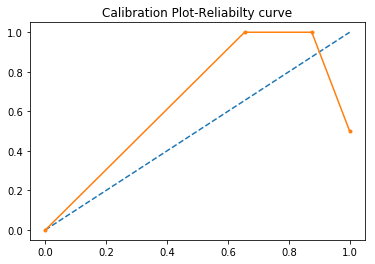

In [44]:
results(X_train, X_test, y_train, y_test,y_pred,"Gaussian NB")

### Probability  Calibration
**To better callibrate our probabilty prediction ,I will use SKlearn's [Probabilty Calibration module](https://scikit-learn.org/stable/modules/calibration.html#calibration).This module adds support for  for probability prediction
A well calibrated classifiers are probabilistic classifiers for which the output of the predict_proba method can be directly interpreted as a confidence level.I have used non-parametric approach for model calibration based on isptonic regression**

In [45]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

Results of Isotonic Calibrated GaussianNB model 

Brier score of the Isotonic Calibrated GaussianNB  model is 0.14817261096853135

                                                    Analytical  Non-Analytical
Title                                                                         
Video Game Designers                                  0.866667        0.133333
Preventive Medicine Physicians                        1.000000        0.000000
Painters, Construction and Maintenance                1.000000        0.000000
Lawyers                                               0.866667        0.133333
Police Identification and Records Officers            0.866667        0.133333
Phlebotomists                                         1.000000        0.000000
Concierges                                            1.000000        0.000000
Credit Analysts                                       0.866667        0.133333
Directors- Stage, Motion Pictures, Television, ...    0.866667        0.133333


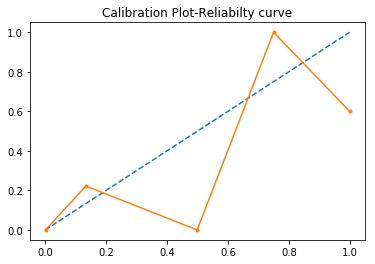

In [46]:
clf_isotonic = CalibratedClassifierCV(gnb, cv="prefit", method='isotonic')
clf_isotonic.fit(X_train, y_train)
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)
results(X_train, X_test, y_train, y_test,prob_pos_isotonic,"Isotonic Calibrated GaussianNB")

**Interpretation of the Results:**
**Brier Score:For the calibrated model is lesser than that of the non calibrated Gaussian NB,so calibration did help in improving prediction. ***

**Calibration Curve:Reliability diagrams allow checking if the predicted probabilities of a classifier are well calibrated. For perfectly calibrated predictions, the curve in a reliability diagram should be as close as possible to the diagonal.Compairing both the graphs we can oberver that after calibration the line curve is closer to the diagonal as compared to the one without calibration.**

**So calibration of our model did help us in improving the performance of the model**

### 5) Potential Issues :

***1) Naive Bayesian assusmes conditional independence between every pair of features given the value of the class variable.Although this might not be the case every time.There can be a possibilty that 2 or more features are dependent on each other in the model.***

***2) The likelihood of the features is assumed to be Gaussian.***
***Which is the conditional likelihood of feature value given a class label as approximated by the conditional distribution fitted to that feature during training. This likelihood is the height of that distribution's probability density function (PDF) at the feature value.Though this is an important assumption it is not a requirment to use the model.Also if we consider the principles of Central Limit Theorem [CLT](https://en.wikipedia.org/wiki/Central_limit_theorem) we can say that when independent random features are added, their properly normalized sum tends toward a normal distribution even if the original features themselves are not normally distributed***

